In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas numpy scikit-learn matplotlib xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 1.1 MB/s eta 0:00:0000:0100:06m
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# === Cell 1: Imports and Config ===
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")



# === Cell 2: Load and Preprocess Data ===
# TODO: set DATA_PATH to your local CSV file path
DATA_PATH = "/media/rohan/c79d22f9-b491-4e0f-8248-6ca5b671d076/major_project2/rainfall_with_correct_flood_labels.csv"

# Load
data = pd.read_csv(DATA_PATH, parse_dates=["TIME"])
# Create a location ID for grouping
data["location_id"] = data["LATITUDE"].astype(str) + "_" + data["LONGITUDE"].astype(str)

# Sort and index
data = data.sort_values(["location_id", "TIME"]).reset_index(drop=True)
data["time_idx"] = (data["TIME"] - data["TIME"].min()).dt.days

# Feature engineering: lag features for rainfall (1 to 7 days)
max_lag = 7
for lag in range(1, max_lag + 1):
    data[f"rain_lag_{lag}"] = data.groupby("location_id")["RAINFALL"].shift(lag)

# Drop rows with NaN from lagging
data = data.dropna().reset_index(drop=True)

print(f"Data shape after lag features: {data.shape}")
print("Sample columns:", data.columns.tolist()[:10])


# === Cell 3: Prepare Features and Target ===
features = [f"rain_lag_{lag}" for lag in range(1, max_lag + 1)]
X = data[features].values
y = data["FLOOD"].astype(int).values

# Train/Test split (stratified on the rare class)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)


# === Cell 4: Define Baseline Models ===
models = {
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    )
}
print("Baseline models defined:", list(models.keys()))


# === Cell 5: Train & Evaluate Baseline Models ===
from sklearn.metrics import accuracy_score

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred)  # Adding accuracy calculation
    
    results.append({
        "Model": name,
        "Precision (Flood)": report["1"]["precision"],
        "Recall (Flood)": report["1"]["recall"],
        "F1 (Flood)": report["1"]["f1-score"],
        "AUC": auc,
        # "Accuracy": accuracy  # Adding accuracy to the results
    })

baseline_df = pd.DataFrame(results).set_index("Model")
print(baseline_df)








Data shape after lag features: (1621392, 16)
Sample columns: ['TIME', 'LATITUDE', 'LONGITUDE', 'RAINFALL', 'FLOOD', 'DISTRICT', 'STATE', 'location_id', 'time_idx', 'rain_lag_1']
Training set shape: (1134974, 7)
Test set shape: (486418, 7)
Baseline models defined: ['LogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost']
                    Precision (Flood)  Recall (Flood)  F1 (Flood)       AUC  \
Model                                                                         
LogisticRegression           0.005132        0.379717    0.010127  0.641997   
DecisionTree                 0.012387        0.008648    0.010185  0.409096   
RandomForest                 0.000000        0.000000    0.000000  0.445015   
XGBoost                      0.005536        0.186321    0.010753  0.531091   

                    Accuracy  
Model                         
LogisticRegression  0.805889  
DecisionTree        0.995605  
RandomForest        0.997245  
XGBoost             0.910351  


In [10]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # [batch, seq_len, 1]
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(X_train_scaled, y_train)
test_ds = SequenceDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return torch.sigmoid(self.fc(hn[-1])).squeeze()

device = torch.device("cpu")
lstm = LSTMClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    lstm.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = lstm(xb.to(device))
        loss = criterion(preds, yb.to(device))
        loss.backward()
        optimizer.step()



In [11]:
# Evaluation
lstm.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = lstm(xb).cpu().numpy()
        preds = (probs > 0.3).astype(int)
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
auc = roc_auc_score(all_labels, all_probs)
if 1 in report:
    print("LSTM Precision, Recall, F1, AUC:", report[1], auc)
elif "1" in report:
    print("LSTM Precision, Recall, F1, AUC:", report["1"], auc)
else:
    print("⚠️ Class 1 not found in evaluation (maybe no positives predicted). AUC:", auc)

⚠️ Class 1 not found in evaluation (maybe no positives predicted). AUC: 0.6626116045414274


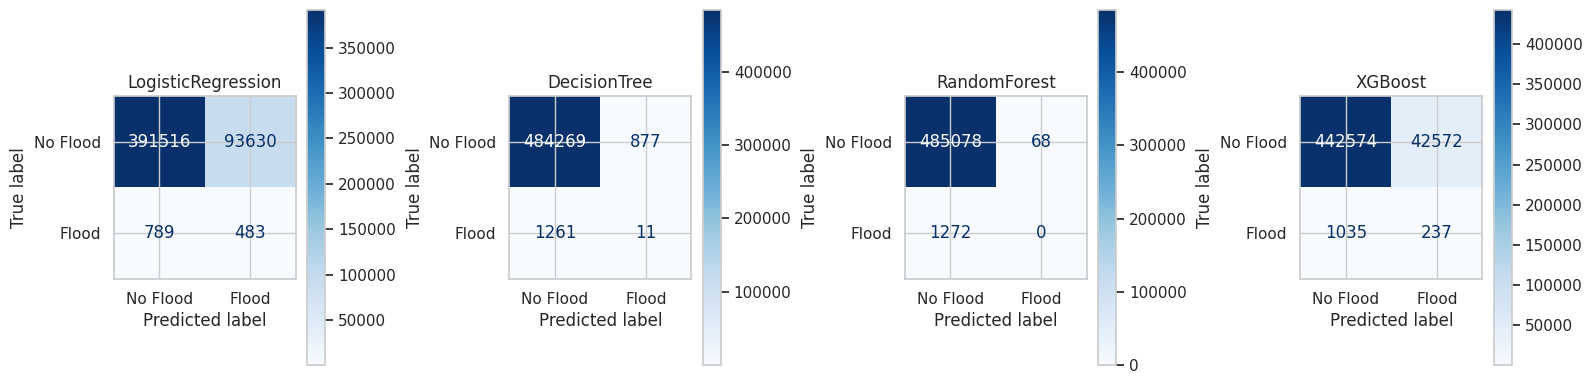

In [15]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# List of models and their predictions
all_model_preds = {
    "LogisticRegression": models["LogisticRegression"].predict(X_test_scaled),
    "DecisionTree": models["DecisionTree"].predict(X_test_scaled),
    "RandomForest": models["RandomForest"].predict(X_test_scaled),
    "XGBoost": models["XGBoost"].predict(X_test_scaled),
}

# Plot confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (name, preds) in zip(axes, all_model_preds.items()):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Flood", "Flood"])
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(name)

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

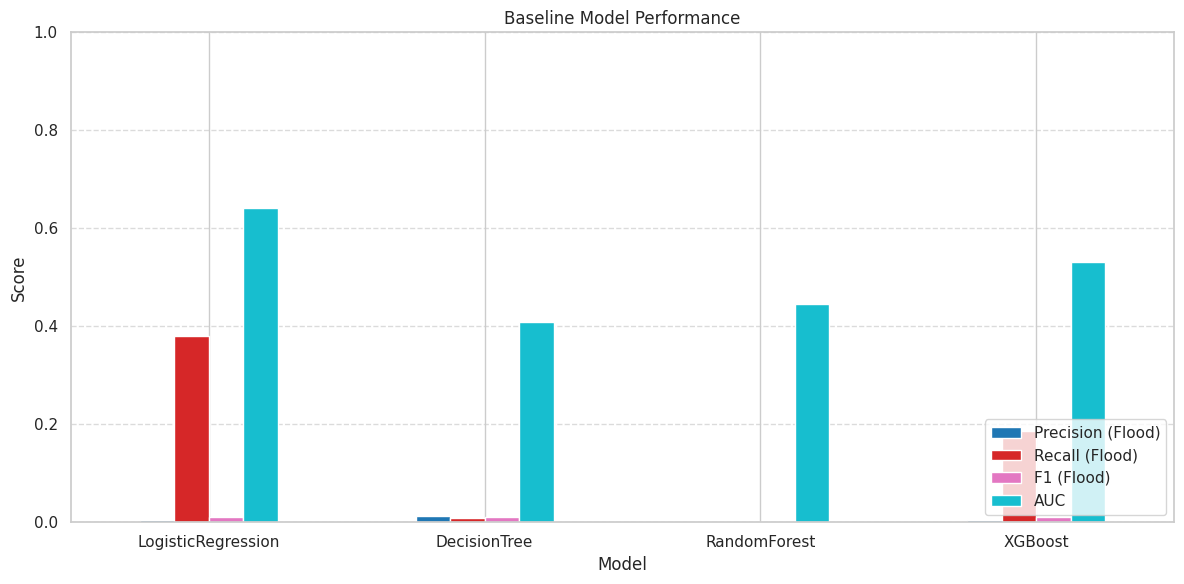

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
metrics = [ "Precision (Flood)", "Recall (Flood)", "F1 (Flood)", "AUC"]

# Plotting
plt.figure(figsize=(12, 6))
baseline_df[metrics].plot(kind="bar", figsize=(12, 6), colormap="tab10")
plt.title("Baseline Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
